# Attention is All You Need를 카피코딩하면서 공부
참고 [The Annotated Transformer](https://paul-hyun.github.io/transformer-01/)
* Pytorch로 구성되어 있음

In [37]:
import sentencepiece as spm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

# 1. Vocab
Sentencepiece를 활용한 Vocab 만들기 예제를 통해 만든 vocab을 이용해 텍스트를 입력 tensor로 변경

In [2]:
# vocab loading
vocab_file = "../Sentencepiece/kowiki.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

# 입력 texts
lines = [
  "겨울은 추워요.",
  "감기 조심하세요.",
    " 이거 왜 이렇게 어려운 거에요?"
]

# text를 tensor로 변환
inputs = []
for line in lines:
    pieces = vocab.encode_as_pieces(line)
    print("pieces: ", pieces)
    ids = vocab.encode_as_ids(line)
    print("ids: ",ids)
    inputs.append(torch.tensor(ids))

# 입력 길이가 다르므로 입력 최대길이에 맞춰 padding(0)을 추가
inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
# shape
print(inputs.size())
# 값
print(inputs)

pieces:  ['▁겨울', '은', '▁추', '워', '요', '.']
ids:  [3091, 3604, 206, 3958, 3760, 3590]
pieces:  ['▁감', '기', '▁조', '심', '하', '세', '요', '.']
ids:  [212, 3605, 53, 3832, 3596, 3682, 3760, 3590]
pieces:  ['▁이', '거', '▁왜', '▁이렇게', '▁어려', '운', '▁거', '에', '요', '?']
ids:  [8, 3729, 1837, 2404, 1748, 3750, 117, 3591, 3760, 4245]
torch.Size([3, 10])
tensor([[3091, 3604,  206, 3958, 3760, 3590,    0,    0,    0,    0],
        [ 212, 3605,   53, 3832, 3596, 3682, 3760, 3590,    0,    0],
        [   8, 3729, 1837, 2404, 1748, 3750,  117, 3591, 3760, 4245]])


# 2. Embedding
Transformer의 Embedding은 'Input Embedding'과 'Position Embedding'두가지를 합해 사용

## Input Embedding
입력 토큰을 vector 형태로 변환

In [3]:
n_vocab = len(vocab)
d_hidn = 128 # hidden size
nn_emb = nn.Embedding(n_vocab, d_hidn)

input_embs = nn_emb(inputs) # input embedding
print(input_embs.size())

torch.Size([3, 10, 128])


## Position Embedding
1. 각 position별로 angle 값을 구한다.
2. 구해진 angle중 2k index에는 sin값을, 2k+1 index에는 cos값을 구한다.

![Position Encoding](./img/position_encoding.png)

In [4]:
""" sinusoid position embedding """
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2*(i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]
    
    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos

    return sinusoid_table

(64, 128)


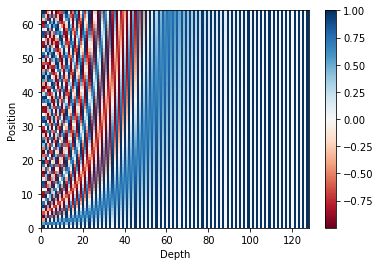

In [5]:
n_seq = 64
pos_encoding = get_sinusoid_encoding_table(n_seq, d_hidn)

print(pos_encoding.shape)
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d_hidn))
plt.ylabel('Position')
plt.colorbar()
plt.show()

position embedding 값을 구하는 법
1. 위에서 구한 position encoding 값을 이용해 position embedding을 생성한다. 학습되는 값이 아니므로 freeze 옵션을 True로 설정한다.
2. 입력 inputs와 동일한 크기를 갖는 positions값을 구한다.
3. input값 중 pad(0)인 부분을 찾아 position값중 pad부분을 0으로 변경한다.
4. positions값에 해당하는 embedding값을 구한다.

In [6]:
pos_encoding = torch.FloatTensor(pos_encoding) #(64, 128)
# 1. position embedding을 생성(freeze=True)
nn_pos = nn.Embedding.from_pretrained(pos_encoding, freeze=True)

# 2. 입력 크기와 동일한 positions 값을 구한다.
positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
pos_mask = inputs.eq(0)

# 3. input값 중 pad==0인 부분을 찾아 position값중 pad==0인 부분을 0으로 변경한다.
positions.masked_fill_(pos_mask, 0)
pos_embs = nn_pos(positions) # position embedding

print(inputs)
print(positions)
print(pos_embs.size())

tensor([[3091, 3604,  206, 3958, 3760, 3590,    0,    0,    0,    0],
        [ 212, 3605,   53, 3832, 3596, 3682, 3760, 3590,    0,    0],
        [   8, 3729, 1837, 2404, 1748, 3750,  117, 3591, 3760, 4245]])
tensor([[ 1,  2,  3,  4,  5,  6,  0,  0,  0,  0],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  0,  0],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])
torch.Size([3, 10, 128])


### position_embedding의 shape와 input_embedding shape는 동일하다.
### 최종 입력값은 input_embs+pos_embs가 된다.

In [7]:
input_sums = input_embs + pos_embs

# 3. Scale Dot Product Attention
![Scale Dot Product Attention](./img/scale_dot_product_attention.png)

### 3 입력값
입력값은 Q(query), K(key), V(value), attention mask로 구성되어 있다.  
입력값 중 K,V는 같은 값이다.  
Q, K, V가 모두 동일한 경우는 self attention이라고 한다.  

In [8]:
Q = input_sums
K = input_sums
V = input_sums
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(attn_mask.size())
print(attn_mask[0])

torch.Size([3, 10, 10])
tensor([[False, False, False, False, False, False,  True,  True,  True,  True],
        [False, False, False, False, False, False,  True,  True,  True,  True],
        [False, False, False, False, False, False,  True,  True,  True,  True],
        [False, False, False, False, False, False,  True,  True,  True,  True],
        [False, False, False, False, False, False,  True,  True,  True,  True],
        [False, False, False, False, False, False,  True,  True,  True,  True],
        [False, False, False, False, False, False,  True,  True,  True,  True],
        [False, False, False, False, False, False,  True,  True,  True,  True],
        [False, False, False, False, False, False,  True,  True,  True,  True],
        [False, False, False, False, False, False,  True,  True,  True,  True]])


### 3.1. MatMul Q, K-transpose
![Scale Dot Product Attention](./img/scale_dot_product_attention.png)
1번 Q와 K를 MatMul

### 3차원 tensor Matmul 예시

In [9]:
a = np.array([[[1,2,1],[3,4,1]], [[5,6,1],[7,8,1]]])
b = np.array([[[1,2], [1,2], [1, 2]], [[2,1], [2,1], [2,1]]])
a = torch.IntTensor(a)
b = torch.IntTensor(b)
print(a.size())
print(b.size())
print(torch.matmul(a, b))

torch.Size([2, 2, 3])
torch.Size([2, 3, 2])
tensor([[[ 4,  8],
         [ 8, 16]],

        [[24, 12],
         [32, 16]]], dtype=torch.int32)


In [10]:
scores = torch.matmul(Q, K.transpose(-1, -2))
print(scores.size())
print(scores[0])

torch.Size([3, 10, 10])
tensor([[186.0099,  72.6959,  56.5929,  59.3229,  41.3768,  40.4290,  53.6514,
          53.6514,  53.6514,  53.6514],
        [ 72.6959, 206.5309,  60.9147,  60.5143,  38.2892,  31.8994,  64.3707,
          64.3707,  64.3707,  64.3707],
        [ 56.5929,  60.9147, 193.5105,  46.8016,  45.1292,  42.6879,  76.3111,
          76.3111,  76.3111,  76.3111],
        [ 59.3229,  60.5143,  46.8016, 172.3411,  70.3230,  37.0118,  44.8177,
          44.8177,  44.8177,  44.8177],
        [ 41.3768,  38.2892,  45.1292,  70.3230, 187.4210,  39.2991,  41.9575,
          41.9575,  41.9575,  41.9575],
        [ 40.4290,  31.8994,  42.6879,  37.0118,  39.2991, 166.1600,  47.3955,
          47.3955,  47.3955,  47.3955],
        [ 53.6514,  64.3707,  76.3111,  44.8177,  41.9575,  47.3955, 188.3397,
         188.3397, 188.3398, 188.3398],
        [ 53.6514,  64.3707,  76.3111,  44.8177,  41.9575,  47.3955, 188.3397,
         188.3397, 188.3398, 188.3398],
        [ 53.6514,  64.3

### 3.2 Scale
![Scale Dot Product Attention](./img/scale_dot_product_attention.png)
2번과 같이 k-dim에 루트를 취한 값으로 나누어준다.

In [11]:
d_head = 64
scores = scores.mul_(1/d_head**0.5)
print(scores.size())
print(scores[0])

torch.Size([3, 10, 10])
tensor([[23.2512,  9.0870,  7.0741,  7.4154,  5.1721,  5.0536,  6.7064,  6.7064,
          6.7064,  6.7064],
        [ 9.0870, 25.8164,  7.6143,  7.5643,  4.7862,  3.9874,  8.0463,  8.0463,
          8.0463,  8.0463],
        [ 7.0741,  7.6143, 24.1888,  5.8502,  5.6412,  5.3360,  9.5389,  9.5389,
          9.5389,  9.5389],
        [ 7.4154,  7.5643,  5.8502, 21.5426,  8.7904,  4.6265,  5.6022,  5.6022,
          5.6022,  5.6022],
        [ 5.1721,  4.7862,  5.6412,  8.7904, 23.4276,  4.9124,  5.2447,  5.2447,
          5.2447,  5.2447],
        [ 5.0536,  3.9874,  5.3360,  4.6265,  4.9124, 20.7700,  5.9244,  5.9244,
          5.9244,  5.9244],
        [ 6.7064,  8.0463,  9.5389,  5.6022,  5.2447,  5.9244, 23.5425, 23.5425,
         23.5425, 23.5425],
        [ 6.7064,  8.0463,  9.5389,  5.6022,  5.2447,  5.9244, 23.5425, 23.5425,
         23.5425, 23.5425],
        [ 6.7064,  8.0463,  9.5389,  5.6022,  5.2447,  5.9244, 23.5425, 23.5425,
         23.5425, 23.54

### 3.3 Mask (Opt.)
![Scale Dot Product Attention](./img/scale_dot_product_attention.png)
3번 mask를 하는 코드

In [12]:
scores.masked_fill_(attn_mask, -1e9)
print(scores.size())
print(scores[0])

torch.Size([3, 10, 10])
tensor([[ 2.3251e+01,  9.0870e+00,  7.0741e+00,  7.4154e+00,  5.1721e+00,
          5.0536e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [ 9.0870e+00,  2.5816e+01,  7.6143e+00,  7.5643e+00,  4.7862e+00,
          3.9874e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [ 7.0741e+00,  7.6143e+00,  2.4189e+01,  5.8502e+00,  5.6412e+00,
          5.3360e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [ 7.4154e+00,  7.5643e+00,  5.8502e+00,  2.1543e+01,  8.7904e+00,
          4.6265e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [ 5.1721e+00,  4.7862e+00,  5.6412e+00,  8.7904e+00,  2.3428e+01,
          4.9124e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [ 5.0536e+00,  3.9874e+00,  5.3360e+00,  4.6265e+00,  4.9124e+00,
          2.0770e+01, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [ 6.7064e+00,  8.0463e+00,  9.5389e+00,  5.6022e+00,  5.2447e+00,
        

### 3.4 Softmax
![Scale Dot Product Attention](./img/scale_dot_product_attention.png)
4번 Softmax

In [13]:
attn_prob = nn.Softmax(dim=-1)(scores)
print(attn_prob.size())
print(attn_prob[0])

torch.Size([3, 10, 10])
tensor([[1.0000e+00, 7.0557e-07, 9.4268e-08, 1.3261e-07, 1.4071e-08, 1.2499e-08,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [5.4265e-08, 1.0000e+00, 1.2444e-08, 1.1836e-08, 7.3569e-10, 3.3099e-10,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.6913e-08, 6.3358e-08, 1.0000e+00, 1.0855e-08, 8.8076e-09, 6.4912e-09,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [7.3215e-07, 8.4972e-07, 1.5306e-07, 1.0000e+00, 2.8957e-06, 4.5019e-08,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.1796e-08, 8.0188e-09, 1.8855e-08, 4.3966e-07, 1.0000e+00, 9.0978e-09,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.4944e-07, 5.1454e-08, 1.9819e-07, 9.7489e-08, 1.2976e-07, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.3808e-02, 1.6729e-01, 7.4418e-01, 1.4521e-02, 1.0156e-02, 2.0042e-02,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
   

### 3.5 MatMul attn_prov, V
![Scale Dot Product Attention](./img/scale_dot_product_attention.png)
5번

In [14]:
context = torch.matmul(attn_prob, V)
print(context.size())

torch.Size([3, 10, 128])


### Scale Dot Product Attention Class 구현
![Scale Dot Product Attention](./img/scale_dot_product_attention.png)

In [27]:
""" scale dot product attention """
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_head):
        super().__init__()
        self.scale = 1 / (d_head ** 0.5)
    
    def forward(self, Q, K, V, attn_mask):
        # 1, 2번
        scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale) # (bs, n_head, n_q_seq, n_k_seq)
        # 3번
        scores.masked_fill_(attn_mask, -1e9) # (bs, n_head, n_q_seq, n_k_seq)
        # 4번
        attn_prob = nn.Softmax(dim=-1)(scores) # (bs, n_head, n_q_seq, n_k_seq)
        # 5번
        context = torch.matmul(attn_prob, V) # (bs, n_head, n_q_seq, v_dim)
        
        return context, attn_prob

# 4. Multi Head attention
![Multi Head Attention](./img/multi_head_attention.png)
### 입력
Q, K, V, attn_mask는 Scale Dot Product Attention과 동일하다.

In [16]:
Q = input_sums
K = input_sums
V = input_sums
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))

batch_size = Q.size(0)
n_head = 2

### Multi Head Q, K, V
![예시](./img/multi_head.png)
1번 Q를 여러개의 head로 나누는 과정

In [17]:
W_Q = nn.Linear(d_hidn, n_head * d_head)
W_K = nn.Linear(d_hidn, n_head * d_head)
W_V = nn.Linear(d_hidn, n_head * d_head)

q_s = W_Q(Q) # (bs, n_seq, n_head * d_head)
print(q_s.size())
q_s = q_s.view(batch_size, -1, n_head, d_head) # (bs, n_seq, n_head, d_head)
print(q_s.size())
q_s = q_s.transpose(1,2)  # (bs, n_head, n_seq, d_head)
print(q_s.size())

torch.Size([3, 10, 128])
torch.Size([3, 10, 2, 64])
torch.Size([3, 2, 10, 64])


위 과정을 한줄로 표현할 수 있다.

In [18]:
q_s = W_Q(Q).view(batch_size, -1, n_head, d_head).transpose(1,2) # (bs, n_head, n_seq, d_head)
k_s = W_K(K).view(batch_size, -1, n_head, d_head).transpose(1,2) # (bs, n_head, n_seq, d_head)
v_s = W_V(V).view(batch_size, -1, n_head, d_head).transpose(1,2) # (bs, n_head, n_seq, d_head)
print(q_s.size(), k_s.size(), v_s.size())

torch.Size([3, 2, 10, 64]) torch.Size([3, 2, 10, 64]) torch.Size([3, 2, 10, 64])


![Scale Dot Product Attention](./img/scale_dot_product_attention.png)
Attention Mask도 Multi Head로 변경

In [19]:
print(attn_mask.size())
attn_mask = attn_mask.unsqueeze(1).repeat(1, n_head, 1, 1)
print(attn_mask.size()) # (bs, n_head, Q_sqe, K_seq)

torch.Size([3, 10, 10])
torch.Size([3, 2, 10, 10])


### 4.4 Attention 과정
![Multi Head Attention](./img/multi_head_attention.png)
4번 Attention과정

In [23]:
scaled_dot_attn = ScaledDotProductAttention(d_head)
# 1, 2, 3을 통과한 데이터를 4에 넣어주는 과정
context, attn_prob = scaled_dot_attn(q_s, k_s, v_s, attn_mask)
print(context.size())
print(attn_prob.size())

torch.Size([3, 2, 10, 64])
torch.Size([3, 2, 10, 10])


### 5번 Concat 과정
Scale Dot Product Attention 과정을 거쳐서 나온 h개수만큼의 head 를 결합한다.

In [24]:
context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_head * d_head) # (bs, n_seq, n_head * d_head)
print(context.size())

torch.Size([3, 10, 128])


### 6번 Liner

In [26]:
linear = nn.Linear(n_head * d_head, d_hidn)
output = linear(context) # (bs, n_seq, d_hidn)
print(output.size())

torch.Size([3, 10, 128])


# Multi Head Attention Class 구현
![Multi Head Attention](./img/multi_head_attention.png)

In [28]:
"""multi head attention"""
class MultiHeadAttention(nn.Module):
    def __init__(self, d_hidn, n_head, d_head):
        super().__init__()
        self.d_hidn = d_hidn
        self.n_head = n_head
        self.d_head = d_head
        
        # 1, 2, 3번 Linear 선언
        self.W_Q = nn.Linear(d_hidn, n_head * d_head)
        self.W_K = nn.Linear(d_hidn, n_head * d_head)
        self.W_V = nn.Linear(d_hidn, n_head * d_head)
        # 4번 선언
        self.scaled_dot_attn = ScaleDotProductAttention(d_head)
        # 6번 선언
        self.linear = nn.Linear(n_head * d_head, d_hidn)
        
    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # 1, 2, 3번 수행
        # (bs, n_head, n_q_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        # (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        # (bs, n_head, n_v_seq, d_head)
        v_s = self.W_V(V).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        
        # Scale Dot Product Attention에서 사용되는 mask를 n_head만큼 복사하여 생성
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_head, 1, 1) # (bs, n_head, n_q_seq, n_k_seq)
        
        # 4번 Scale Dot Product Attention 수행
        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        
        # 5번 Scale Dot Product Attention후 Concatenate하는 과정
        # (bs, n_head, n_q_seq, h_head * d_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_head * self.d_head)
        
        # 6번 Linear
        output = self.linear(context) # (bs, n_head, n_q_seq, e_embd)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        return output, attn_prob

# Masked Multi-Head Attention
MultiHeadAttention Class에 mask를 제외한 모든 부분이 동일하다.  
Encoder에서 사용되는 Mask와 다르게 <Pad> 뿐만 아니라 decoder 입력까지 생각을 해서 Mask를 구성해야 한다.

In [29]:
""" attention decoder mask """
def get_attn_decoder_mask(seq):
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = subsequent_mask.triu(diagonal=1) # upper triangular part of a matrix(2-D)
    return subsequent_mask


Q = input_sums
K = input_sums
V = input_sums

attn_pad_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(attn_pad_mask[1])
attn_dec_mask = get_attn_decoder_mask(inputs)
print(attn_dec_mask[1])
attn_mask = torch.gt((attn_pad_mask + attn_dec_mask), 0)
print(attn_mask[1])

batch_size = Q.size(0)
n_head = 2

tensor([[False, False, False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False, False, False,  True,  True]])
tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],

In [30]:
"""Decoder에 적용되는 Multi Head Attention"""
attention = MultiHeadAttention(d_hidn, n_head, d_head)
output, attn_prob = attention(Q, K, V, attn_mask)
print(output.size(), attn_prob.size())

torch.Size([3, 10, 128]) torch.Size([3, 2, 10, 10])


# FeedForward
![FeedForward](./img/feed-forward.png)

### f1 (Linear)
1번 과정  
입력에 비해서 hidden dimension이 4배 커진다.

In [31]:
conv1 = nn.Conv1d(in_channels=d_hidn, out_channels=d_hidn * 4, kernel_size=1)
# (bs, d_hidn * 4, n_seq)
ff_1 = conv1(output.transpose(1, 2))
print(ff_1.size())

torch.Size([3, 512, 10])


### f2 (Activation)
초기 논문에는 relu를 사용했으나 gelu가 더 좋다는 것이 발표됨

In [39]:
activation = F.gelu
ff_2 = activation(ff_1)

### f3 (Linear)

In [40]:
conv2 = nn.Conv1d(in_channels=d_hidn * 4, out_channels=d_hidn, kernel_size=1)
ff_3 = conv2(ff_2).transpose(1, 2)
print(ff_3.size())

torch.Size([3, 10, 128])


In [41]:
# FeedForward Class 구현
""" feed forward """
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_hidn):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_hidn * 4, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_hidn * 4, out_channels=self.config.d_hidn, kernel_size=1)
        self.active = F.gelu

    def forward(self, inputs):
        # (bs, d_ff, n_seq)
        output = self.active(self.conv1(inputs.transpose(1, 2)))
        # (bs, n_seq, d_hidn)
        output = self.conv2(output).transpose(1, 2)
        # (bs, n_seq, d_hidn)
        return output

## Model Architecture
![도식](./img/encoder-decoder.png)
![Attention Model](./img/archi2.png)


### Position-wise Feed-Forward Networks
* Encoder와 Dencoder에서 구성되어 있는 FCN을 설정한다.
* 논문에서는 FCN이 each position을 separately and identically한다고 한다.
* 두개의 linear transformation과 ReLU로 구성되어 있다.

## Encoder and Decoder Stacks
### Encoder
encoder는 **6**개를 연결하여 구성되어 있다.